In [1]:
%config InlineBackend.figure_formats = ['svg']

In [110]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

In [3]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

class VQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        def objective(x):
            job = self._estimator.run([self._circuit], [operators], [x])
            estimator_result = job.result()
            value = estimator_result.values[0]
            if self._callback is not None:
                self._callback(value)
            return value
            
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        res = self._optimizer.minimize(objective, x0=x0)
        

        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

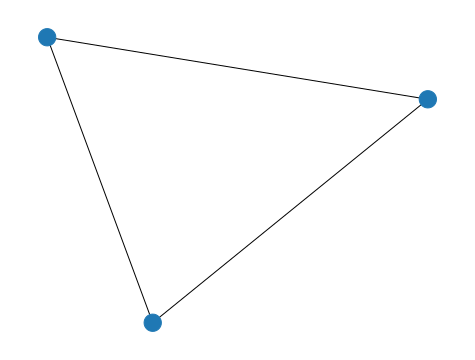

In [4]:
num_sites = 3
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 0, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [5]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZI', 'ZIZ', 'IZZ', 'YYI', 'YIY', 'IYY', 'XXI', 'XIX', 'IXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [172]:
print(hamiltonian.eval().primitive.data.astype(int))

[[ 3  0  0  0  0  0  0  0]
 [ 0 -1  2  0  2  0  0  0]
 [ 0  2 -1  0  2  0  0  0]
 [ 0  0  0 -1  0  2  2  0]
 [ 0  2  2  0 -1  0  0  0]
 [ 0  0  0  2  0 -1  2  0]
 [ 0  0  0  2  0  2 -1  0]
 [ 0  0  0  0  0  0  0  3]]


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_24364/1530903205.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(hamiltonian.eval().primitive.data.astype(int))


In [186]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [188]:
print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))

\begin{bmatrix}
  3 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & -1 & 2 & 0 & 2 & 0 & 0 & 0\\
  0 & 2 & -1 & 0 & 2 & 0 & 0 & 0\\
  0 & 0 & 0 & -1 & 0 & 2 & 2 & 0\\
  0 & 2 & 2 & 0 & -1 & 0 & 0 & 0\\
  0 & 0 & 0 & 2 & 0 & -1 & 2 & 0\\
  0 & 0 & 0 & 2 & 0 & 2 & -1 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 3\\
\end{bmatrix}


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_24364/2407667632.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))


In [182]:
for jawn in hamiltonian.eval().primitive.data.astype(int):
    print("{", ",".join(map(str, jawn)), "},")

{ 3,0,0,0,0,0,0,0 },
{ 0,-1,2,0,2,0,0,0 },
{ 0,2,-1,0,2,0,0,0 },
{ 0,0,0,-1,0,2,2,0 },
{ 0,2,2,0,-1,0,0,0 },
{ 0,0,0,2,0,-1,2,0 },
{ 0,0,0,2,0,2,-1,0 },
{ 0,0,0,0,0,0,0,3 },


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_24364/4023989667.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  for jawn in hamiltonian.eval().primitive.data.astype(int):


In [183]:
exact_solver = ClassicalEigensolver(k=4)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-3. -3. -3. -3.]


In [184]:
for amplitude in exact_result.eigenstates[0].primitive.data:
    print(f"{np.abs(amplitude):.4f}, {np.angle(amplitude):.4f}")

0.0000, 0.0531
0.2465, -2.7790
0.5957, 2.3445
0.1545, 1.5168
0.7301, -0.4824
0.0457, -0.0985
0.1592, -1.9158
0.0000, -1.9562


Ground State #0


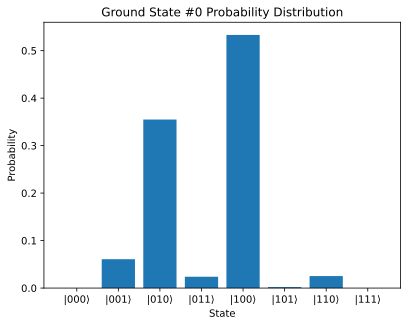

Probabilities
	|000> ==> 0.000
	|001> ==> 0.061
	|010> ==> 0.355
	|011> ==> 0.024
	|100> ==> 0.533
	|101> ==> 0.002
	|110> ==> 0.025
	|111> ==> 0.000

Ground State #1


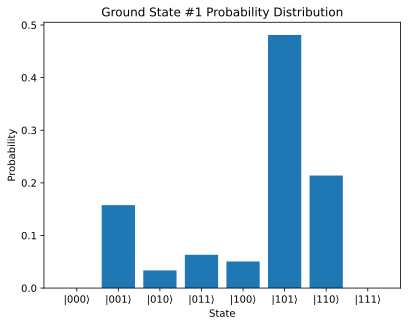

Probabilities
	|000> ==> 0.000
	|001> ==> 0.158
	|010> ==> 0.034
	|011> ==> 0.063
	|100> ==> 0.051
	|101> ==> 0.481
	|110> ==> 0.214
	|111> ==> 0.000

Ground State #2


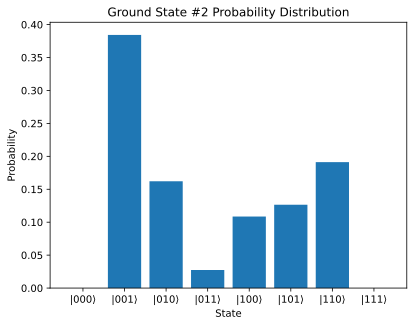

Probabilities
	|000> ==> 0.000
	|001> ==> 0.384
	|010> ==> 0.162
	|011> ==> 0.027
	|100> ==> 0.109
	|101> ==> 0.126
	|110> ==> 0.191
	|111> ==> 0.000

Ground State #3


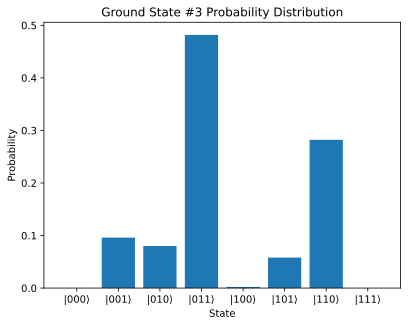

Probabilities
	|000> ==> 0.000
	|001> ==> 0.096
	|010> ==> 0.080
	|011> ==> 0.482
	|100> ==> 0.002
	|101> ==> 0.058
	|110> ==> 0.282
	|111> ==> 0.000



In [185]:
for index, statevector in enumerate(exact_result.eigenstates):
        print(f"Ground State #{index}")

        states = [f"{state:03b}" for state in range(2**3)]
        probabilities = [ np.abs(statevector.primitive.data[state]) ** 2 for state in range(2**3) ]

        plt.bar([f"$|{state}\\rangle$" for state in states], probabilities)
        plt.xlabel("State")
        plt.ylabel("Probability")
        plt.title(f"Ground State #{index} Probability Distribution")
        plt.show()

        print("Probabilities")
        for state, probability in zip(states, probabilities):
            print(f"\t|{state}> ==> {probability:.3f}")

        print()

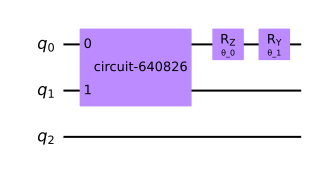

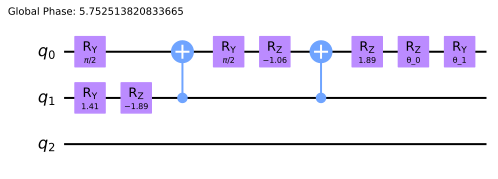

In [152]:
ansatz_sv = np.zeros(2**2, dtype=np.cdouble)
ansatz_sv[1] = exact_result.eigenstates[0].primitive.data[1]
ansatz_sv[2] = exact_result.eigenstates[0].primitive.data[2]
ansatz_sv = VectorStateFn(ansatz_sv / np.linalg.norm(ansatz_sv))
ansatz_sv

ansatz_small = ansatz_sv.to_circuit_op().to_circuit()

ansatz = QuantumCircuit(3)
ansatz.append(ansatz_small, [0, 1])

ansatz.rz(Parameter('θ_0'), 0)
ansatz.ry(Parameter('θ_1'), 0)

display(ansatz.draw("mpl"))

ansatz = transpile(ansatz, basis_gates=['cx', 'rz', 'ry'])

ansatz.draw("mpl")

In [153]:
optimizer = ADAM(maxiter=1000)
# optimizer = NFT(maxiter=1000)

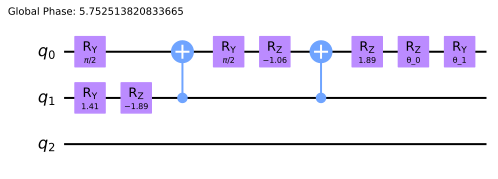

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1000,
    'eigenstate': None,
    'eigenvalue': -2.973235316145649,
    'optimal_circuit': None,
    'optimal_parameters': array([-0.63486021,  0.0021091 ]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
Execution Time (s): 1.99


In [154]:
display(ansatz.draw("mpl"))

intermediate_info = []
def callback(value):
        intermediate_info.append(value)

estimator = Estimator([ansatz], [hamiltonian])

vqe = VQE(estimator, ansatz, optimizer, callback=callback)

start = time()
result = vqe.compute_minimum_eigenvalue(hamiltonian)
end = time()

print(result)
print(f'Execution Time (s): {end - start:.2f}')

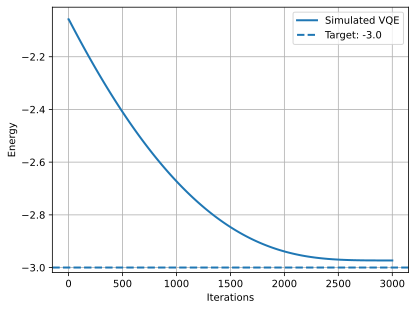

In [155]:
plt.plot(intermediate_info, lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')

plt.axhline(y=gs_energy, ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
# plt.show()

plt.savefig('optimization.svg', format="svg")

In [156]:
def relative_error(target, measured):
    return abs((target - measured) / target)

error = relative_error(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}.')
print(f'Computed ground state energy: {result.eigenvalue:.10f}.')
print(f'Relative error: {error:.8f}.')

Expected ground state energy: -3.0000000000.
Computed ground state energy: -2.9732353161.
Relative error: 0.00892156.
